Conda env: `aops_mathbert`

In [1]:
import numpy as np
import pandas as pd
from time import perf_counter

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
from official.nlp import optimization  # to create AdamW optimizer

from transformers import BertTokenizer, TFBertModel

def compare_actual_and_predict_values(model, tokenized_list_of_texts, list_of_texts, list_of_actual):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    predicted = []
    for i in range(len(tokenized_list_of_texts[0])):
        temp = model([[tokenized_list_of_texts[0][i]], [tokenized_list_of_texts[1][i]], [tokenized_list_of_texts[2][i]]])
        temp = temp.numpy().flatten()[0]
        predicted.append(temp)
    predicted = np.array(predicted)
    list_of_actual = np.array(list_of_actual)
    
    for i in range(len(list_of_texts)):
        print(f"{str(i+1):>2s}. {list_of_texts[i]}")
        print(f"    Actual   Predicted")
        print(f"    {list_of_actual[i]:.3f}    {predicted[i]:.3f}")
        print()

    df_ = pd.DataFrame({
        'actual': list_of_actual,
        'predicted': predicted
    })
    pd.set_option('display.max_rows', 500)
    display(df_)
    print(f"           actual              predict")
    print(f"Average    {np.average(list_of_actual)}    {np.average(predicted)}")
    print(f"Variance   {np.var(list_of_actual)}    {np.var(predicted)}")
    print(f"STD        {np.std(list_of_actual)}    {np.std(predicted)}")
    print()

    loss_sk = mean_squared_error(y_true=list_of_actual, y_pred=predicted)
    mae_sk = mean_absolute_error(y_true=list_of_actual, y_pred=predicted)
    r2_sk = r2_score(y_true=list_of_actual, y_pred=predicted)
    print(f"loss(mse)            mae                   r2")
    print(f"{loss_sk}    {mae_sk}    {r2_sk}")

    fig, ax = plt.subplots(1, 1, figsize=(16, 6), constrained_layout=True)
    sns.kdeplot(list_of_actual, label='Actual', shade=True, color='blue', linewidth=2)
    sns.kdeplot(predicted, label='Predicted', shade=True, color='red', linewidth=2)

    plt.xlim((-1, 11))
    plt.title('Density Plot of Actual & Predicted Values')
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.legend()

    fig, ax = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
    plt.subplot(1, 2, 1)
    plt.xlim((-1, 11))
    sns.kdeplot(list_of_actual, label='Actual', shade=True, color='blue', linewidth=2)
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.kdeplot(predicted, label='Predicted', shade=True, color='red', linewidth=2)
    plt.legend()

    # Scatter plot
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), constrained_layout=True)
    plt.subplot(1, 1, 1)
    plt.scatter(list_of_actual, predicted, color='blue', marker='o', label='Data Points')
    fx_x = np.linspace(0, 10, 100)  # Generate x values for the line
    plt.plot(fx_x, fx_x, color='red', linestyle='--', label='f(x) = x')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Scatter Plot of Predict & Actual')
    plt.grid(True)
    plt.legend()

    # Set x and y axis limits to range from 0 to 10
    plt.xlim(0, 10)
    plt.ylim(0, 10)

    plt.show()

def tokenize_text(array, max_length=512, return_tensor:bool = False):
    tokenizer = BertTokenizer.from_pretrained('tbs17/MathBERT', output_hidden_states=True)
    tokenized_list = tokenizer(array, padding='max_length', max_length=max_length, truncation=True, return_tensors='tf')
    
    if type(return_tensor) is not bool:
        raise TypeError(f"return_tensor must a boolean. Found return_tensor={type(return_tensor)}")
    if return_tensor is True:
        return tf.data.Dataset.from_tensor_slices((tokenized_list['input_ids'], tokenized_list['attention_mask'], tokenized_list['token_type_ids']))
    if return_tensor is False:
        return tokenized_list['input_ids'], tokenized_list['attention_mask'], tokenized_list['token_type_ids']
    

c:\Users\victo\anaconda3\envs\aops_mathbert\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\victo\anaconda3\envs\aops_mathbert\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file

## Example

In [ ]:
tokenizer = BertTokenizer.from_pretrained('tbs17/MathBERT', output_hidden_states=True)
encoder = TFBertModel.from_pretrained("tbs17/MathBERT", from_pt=True)

In [ ]:
example_text = "Determine all functions f : mathbb R to mathbb R satisfying the following two conditions: (a) f(x + y) + f(x - y) = 2f(x)f(y) for all x, y in mathbb R, and (b) lim_{x to infty} f(x) = 0."
encoded_inputs = tokenizer(example_text, return_tensors="tf", padding="max_length", max_length=512, truncation=True)

print(f"output keys                     -> {list(encoded_inputs.keys())}")
print(f"input_word_ids _ input_ids      -> {encoded_inputs['input_ids'][0, :12]}")
print(f"input_mask _ attention_mask     -> {encoded_inputs['attention_mask'][0, :12]}")
print(f"input_type_ids _ token_type_ids -> {encoded_inputs['token_type_ids'][0, :12]}")
print(f"shape: {encoded_inputs['attention_mask'].shape}\n")

# output = model(encoded_inputs)
# output

In [ ]:
example_text = 'hElLO an bisa the aku'
encoded_inputs = tokenizer(example_text, return_tensors="tf", padding="max_length", max_length=12, truncation=True)

print(f"INPUT TEXT               --> '{example_text}'")
print(f"tokenize                 --> {tokenizer.tokenize(example_text)}")
print(f"decode                   --> {tokenizer.decode(encoded_inputs['input_ids'][0])}")
print(f"encode                   --> {tokenizer.encode(example_text)}")
print(f"convert_ids_to_tokens    --> {tokenizer.convert_ids_to_tokens([101, 7592, 2019, 20377, 2050, 1996, 17712, 2226, 102])}")
print(f"convert_tokens_to_ids    --> {tokenizer.convert_tokens_to_ids(['[CLS]', 'hello', 'an', 'bis', '##a', 'the', 'ak', '##u', '[SEP]'])}")
print(f"convert_tokens_to_string --> {tokenizer.convert_tokens_to_string(['hello', 'an', 'bis', '##a', 'the', 'ak', '##u'])}")

print()
print(f"cls_token : {tokenizer.cls_token}  - cls_token_id: {tokenizer.cls_token_id}")
print(f"mask_token: {tokenizer.mask_token} - mask_token_id: {tokenizer.mask_token_id}")
print(f"pad_token : {tokenizer.pad_token}  - pad_token_id: {tokenizer.pad_token_id} - pad_token_type_id: {tokenizer.pad_token_type_id}")
print(f"unk_token : {tokenizer.unk_token}  - unk_token_id: {tokenizer.unk_token_id}")
print(f"sep_token : {tokenizer.sep_token}  - sep_token_id: {tokenizer.sep_token_id}")
print()
print(f"all_special_ids             --> {tokenizer.all_special_ids}")
print(f"all_special_tokens          --> {tokenizer.all_special_tokens}")
print(f"all_special_tokens_extended --> {tokenizer.all_special_tokens_extended}")
print()
print(f"name_or_path              --> {tokenizer.name_or_path}")
print(f"vocab_size                --> {tokenizer.vocab_size}")
print(f"model_max_length          --> {tokenizer.model_max_length}")
print(f"model_input_names         --> {tokenizer.model_input_names}")
print(f"prepare_for_model         --> {tokenizer.prepare_for_model([101, 7592, 2019, 20377])}")

print(f"SPECIAL_TOKENS_ATTRIBUTES --> {tokenizer.SPECIAL_TOKENS_ATTRIBUTES}")


## Prepare & Load Dataset

In [2]:
def load_tokenized_train_val_test_ds(path, batch_size, seed, AUTOTUNE=tf.data.AUTOTUNE):
    df_train = pd.read_csv(f"{path}train.csv")
    df_test = pd.read_csv(f"{path}test.csv")
    df_val = pd.read_csv(f"{path}val.csv")

    train_post_canonical = list(df_train['post_canonical'].values)
    train_score = df_train['score'].values

    test_post_canonical = list(df_test['post_canonical'].values)
    test_score = df_test['score'].values

    val_post_canonical = list(df_val['post_canonical'].values)
    val_score = df_val['score'].values

    tokenized_train = tokenize_text(train_post_canonical, max_length=512, return_tensor=False)
    tokenized_val = tokenize_text(val_post_canonical, max_length=512, return_tensor=False)
    tokenized_test = tokenize_text(test_post_canonical, max_length=512, return_tensor=False)
    
    train_ds = tf.data.Dataset.from_tensor_slices((tokenized_train, train_score))
    val_ds = tf.data.Dataset.from_tensor_slices((tokenized_val, val_score))
    test_ds = tf.data.Dataset.from_tensor_slices((tokenized_test, test_score))
    
    train_ds = train_ds.shuffle(buffer_size=len(df_train), seed=seed).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    
    return train_ds, val_ds, test_ds

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16
seed = 42


## Modeling

In [3]:
class MathBertRegressorModel:
    def __init__(self, max_length=512) -> None:
        self.max_length = max_length
        self.encoder = TFBertModel.from_pretrained("tbs17/MathBERT", from_pt=True)
        
        self.model = self.build_model()
        
        self.train_ds = None
        self.validation_data = None
        self.epochs = None
        
        self.history = None

    def build_model(self):
        input_ids_layer = tf.keras.Input(shape=(self.max_length,), dtype=tf.int32, name='input_ids_layer')
        attention_mask_layer = tf.keras.Input(shape=(self.max_length,), dtype=tf.int32, name='attention_mask_layer')
        token_type_ids_layer = tf.keras.Input(shape=(self.max_length,), dtype=tf.int32, name='token_type_ids_layer')
        inputs = [input_ids_layer, attention_mask_layer, token_type_ids_layer]
        
        self.encoder.trainable = False
        encoded_text = self.encoder(
            input_ids=input_ids_layer, 
            attention_mask=attention_mask_layer,
            token_type_ids=token_type_ids_layer)
        last_hidden_state = encoded_text['last_hidden_state'][:, 0, :]  # Output -> dict.keys(['last_hidden_state', 'pooler_output'])
        
        net = tf.keras.layers.Dropout(0.1)(last_hidden_state)
        net = tf.keras.layers.Dense(512, activation='relu')(net)
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(256, activation='relu')(net)
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(128, activation='relu')(net)
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(1, activation='linear')(net)
    
        return tf.keras.Model(inputs=inputs, outputs=net)
    
    def compile_model(self, train_ds, validation_data, epochs, learning_rate, optimizer_type='adamw', loss=tf.keras.losses.mean_squared_error, metrics=['mae']):
        self.train_ds = train_ds
        self.validation_data = validation_data
        self.epochs = epochs
        
        steps_per_epoch = tf.data.experimental.cardinality(self.train_ds).numpy()
        num_train_steps = steps_per_epoch * self.epochs
        optimizer = optimization.create_optimizer(
            init_lr=learning_rate,
            num_train_steps=num_train_steps,
            num_warmup_steps=int(0.1*num_train_steps),
            optimizer_type=optimizer_type
        )
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def train(self):
        print("Start training..")
        start = perf_counter()
        history = self.model.fit(
            self.train_ds, 
            validation_data=self.validation_data, 
            epochs=self.epochs
        )
        end = perf_counter()
        print(f"\nTotal training time: {end-start:.2f}s")

        self.history = history.history
        return history
    
    def evaluate_test(self, test_ds):
        loss, mae = self.model.evaluate(test_ds)
        return {'loss': loss, 'mae': mae}
        
    def plot_training_history_over_time(self, figsize=(14, 12)):
        print(self.history.keys())
        print("Training history over time")
        
        mae = self.history['mae']
        val_acc = self.history['val_mae']
        loss = self.history['loss']
        val_mae = self.history['val_mae']
        epochs = range(1, len(mae) + 1)
        
        figure, ax = plt.subplots(2, 1, figsize=figsize, layout="constrained")
        # loss
        plt.subplot(2, 1, 1)
        plt.plot(epochs, loss, 'r', label='Training loss')
        plt.plot(epochs, val_mae, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')

        # mae
        plt.subplot(2, 1, 2)
        plt.plot(epochs, mae, 'r', label='Training mae')
        plt.plot(epochs, val_acc, 'b', label='Validation mae')
        plt.title('Training and validation mae')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend(loc='upper right')

epochs = 64
learning_rate = 1e-4
optimizer_type = 'adamw'
loss = tf.keras.losses.mean_squared_error
metrics = ['mae']


## `IMO`

### 1. Compile

In [4]:
train_ds, val_ds, test_ds = load_tokenized_train_val_test_ds(path="../data/regression/imo/", batch_size=batch_size, seed=seed, AUTOTUNE=AUTOTUNE)


In [5]:
mathbert_regressor_model = MathBertRegressorModel()
mathbert_regressor_model.compile_model(
    train_ds, 
    val_ds, 
    epochs=epochs, 
    learning_rate=learning_rate, 
    optimizer_type=optimizer_type, 
    loss=loss, 
    metrics=metrics
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

### 2. Training

In [6]:
mathbert_regressor_model.train()


Start training..
Epoch 1/64
18/18 [==============================] - 16s 322ms/step - loss: 27.2150 - mae: 4.6892 - val_loss: 19.9741 - val_mae: 4.0258
Epoch 2/64
18/18 [==============================] - 3s 166ms/step - loss: 20.6958 - mae: 3.9568 - val_loss: 10.8054 - val_mae: 2.7436
Epoch 3/64
18/18 [==============================] - 3s 169ms/step - loss: 10.4159 - mae: 2.6418 - val_loss: 4.5782 - val_mae: 1.8318
Epoch 4/64
18/18 [==============================] - 3s 167ms/step - loss: 6.1807 - mae: 2.0330 - val_loss: 5.2407 - val_mae: 1.8750
Epoch 5/64
18/18 [==============================] - 3s 168ms/step - loss: 5.5266 - mae: 1.9530 - val_loss: 3.9786 - val_mae: 1.7142
Epoch 6/64
18/18 [==============================] - 3s 170ms/step - loss: 5.3568 - mae: 1.9257 - val_loss: 4.2067 - val_mae: 1.7206
Epoch 7/64
18/18 [==============================] - 3s 166ms/step - loss: 5.4349 - mae: 1.8984 - val_loss: 4.0998 - val_mae: 1.7384
Epoch 8/64
18/18 [==============================] - 3

### 3. Evaluate test

In [11]:
result = mathbert_regressor_model.evaluate_test(test_ds)
loss, mae = result['loss'], result['mae']
print()
print(f'Loss : {loss}')
print(f'MAE  : {mae}')


5/5 [==============================] - 1s 120ms/step - loss: 6.9029 - mae: 2.1576

Loss : 6.902899265289307
MAE  : 2.157618761062622


### 4. Plot epoch over time

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
Training history over time


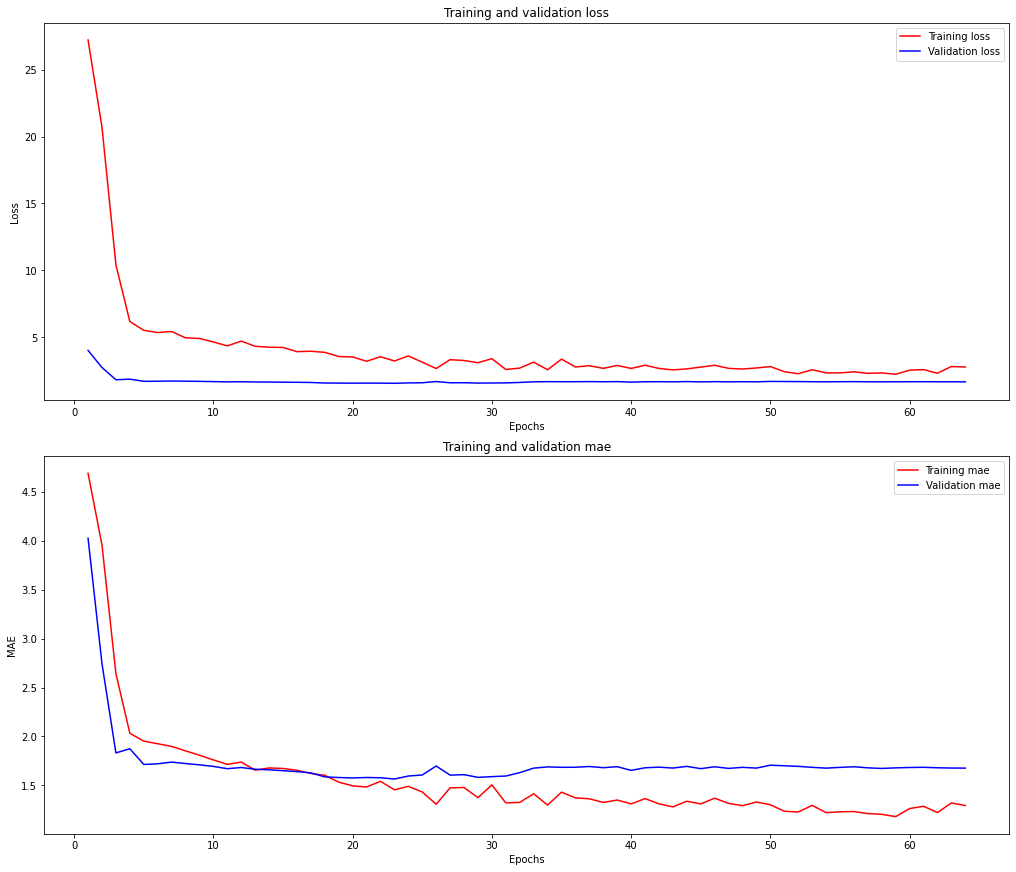

In [12]:
mathbert_regressor_model.plot_training_history_over_time()


### 5. Save model

In [13]:
temp_path = "saved_models/regression/IMO-MATHBERT"
mathbert_regressor_model.model.save(temp_path)


INFO:tensorflow:Assets written to: saved_models/regression/IMO-MATHBERT\assets


INFO:tensorflow:Assets written to: saved_models/regression/IMO-MATHBERT\assets


### Reload model (compare actual & predict)

 1. Find the smallest natural number n which has the following properties: a) Its decimal representation has a 6 as the last digit. b) If the last digit 6 is erased and placed in front of the remaining digits, the resulting number is four times as large as the original number n.
    Actual   Predicted
    0.980    5.133

 2. Construct triangle ABC, given h_a, h_b (the altitudes from A and B), and m_a, the median from vertex A.
    Actual   Predicted
    1.000    4.164

 3. Find all natural numbers n the product of whose decimal digits is n^2-10n-22.
    Actual   Predicted
    1.334    6.074

 4. Let f be an injective function from {1,2,3, ldots} in itself. Prove that for any n we have: sum_{k=1}^{n} f(k)k^{-2} geq sum_{k=1}^{n} k^{-1}.
    Actual   Predicted
    1.616    5.145

 5. Determine all composite integers n>1 that satisfy the following property: if d_1, d_2, ldots, d_k are all the positive divisors of n with 1=d_1<d_2< cdots<d_k=n, then d_i divides d_{i+1}+d_{i+2} for every 1 

,actual,predicted
0,0.980392,5.133295
1,1.000000,4.163917
2,1.334380,6.074011
3,1.616162,5.144599
4,1.734198,7.506474
5,2.136855,4.901266
6,2.212693,5.892653
7,2.214839,6.319242
8,2.225535,7.035576
9,2.362345,5.510769


           actual              predict
Average    5.16082575388927    5.5167765617370605
Variance   5.326022509214558    1.1167746782302856
STD        2.3078176941029285    1.0567755699157715

loss(mse)            mae                   r2
6.903336969039345    2.15777220293148    -0.2961524208911761


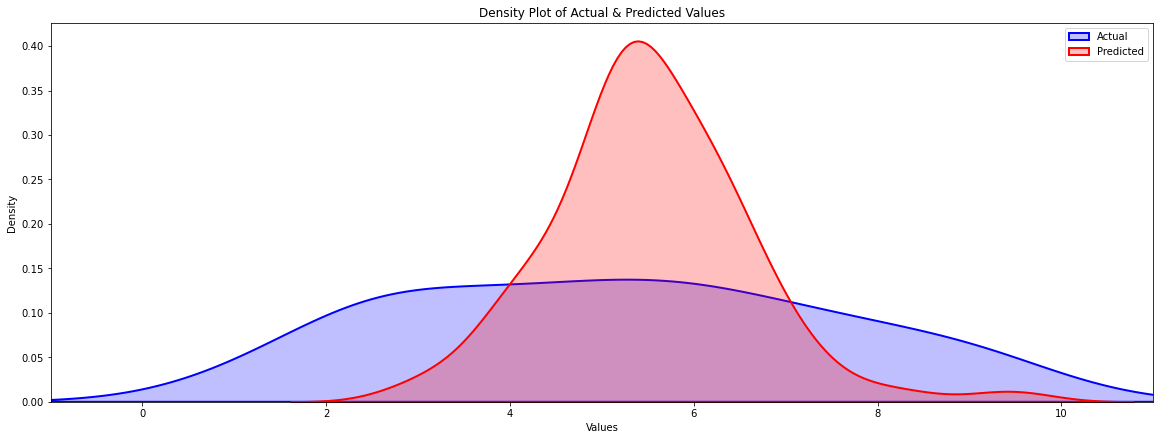

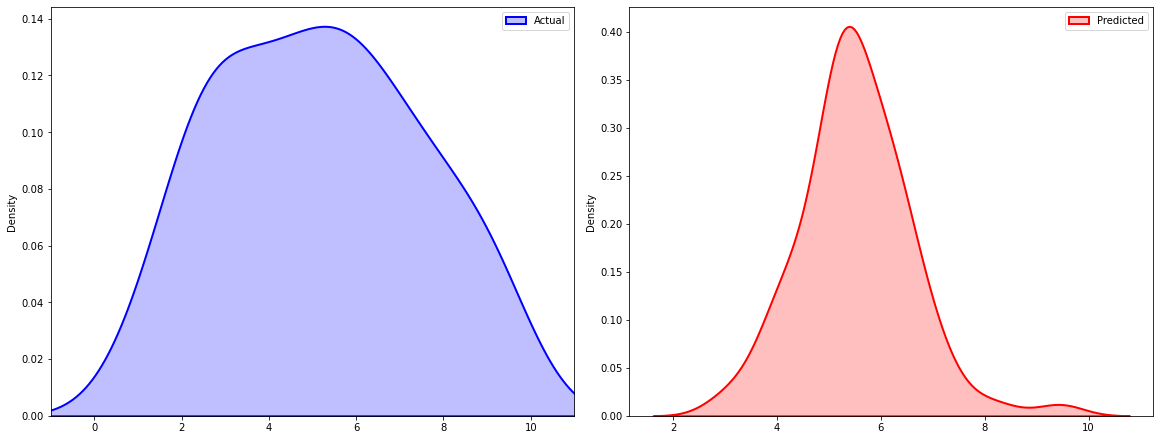

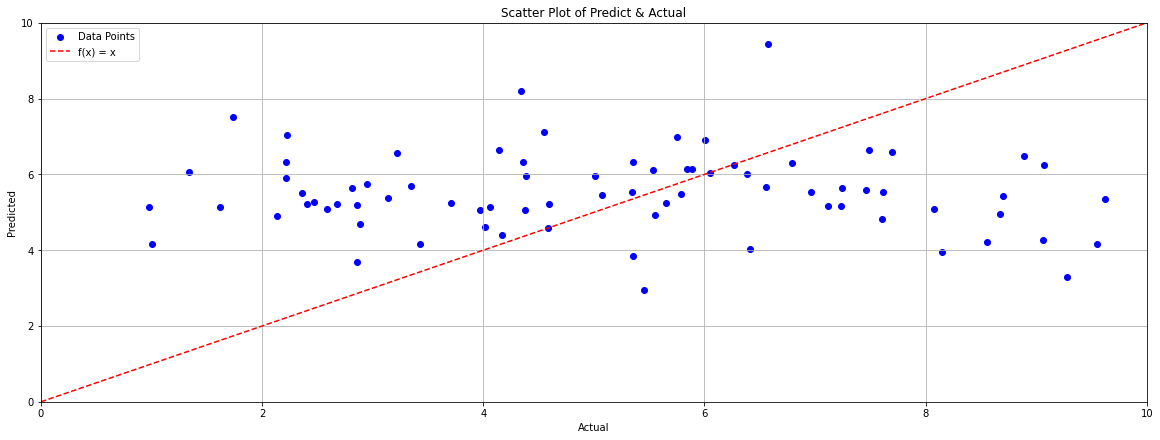

In [2]:
df = pd.read_csv("../data/regression/imo/test.csv")
df.sort_values(by=['score'], inplace=True)
df.reset_index(inplace=True)
examples_texts = list(df['post_canonical'].values)
tokenized_examples_texts = tokenize_text(examples_texts, max_length=512, return_tensor=False)
examples_scores = df['score'].values

reloaded_model = tf.saved_model.load('saved_models/regression/IMO-MATHBERT')
compare_actual_and_predict_values(reloaded_model, tokenized_examples_texts, examples_texts, examples_scores)


## `COMBINED_ALL`

### 1. Compile

In [4]:
train_ds, val_ds, test_ds = load_tokenized_train_val_test_ds(path="../data/regression/", batch_size=batch_size, seed=seed, AUTOTUNE=AUTOTUNE)


In [5]:
mathbert_regressor_model = MathBertRegressorModel()
mathbert_regressor_model.compile_model(
    train_ds, 
    val_ds, 
    epochs=epochs, 
    learning_rate=learning_rate, 
    optimizer_type=optimizer_type, 
    loss=loss, 
    metrics=metrics
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'bert.embeddings.position_ids', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

### 2. Training

In [6]:
mathbert_regressor_model.train()


Start training..
Epoch 1/64
27/27 [==============================] - 17s 270ms/step - loss: 31.3123 - mae: 5.0953 - val_loss: 26.4385 - val_mae: 4.7295
Epoch 2/64
27/27 [==============================] - 5s 170ms/step - loss: 21.2218 - mae: 4.0310 - val_loss: 11.0207 - val_mae: 2.8310
Epoch 3/64
27/27 [==============================] - 5s 169ms/step - loss: 8.8910 - mae: 2.4286 - val_loss: 4.9707 - val_mae: 1.8674
Epoch 4/64
27/27 [==============================] - 5s 171ms/step - loss: 6.2871 - mae: 2.0427 - val_loss: 3.9961 - val_mae: 1.6302
Epoch 5/64
27/27 [==============================] - 5s 180ms/step - loss: 6.1951 - mae: 2.0639 - val_loss: 3.7806 - val_mae: 1.5650
Epoch 6/64
27/27 [==============================] - 5s 175ms/step - loss: 5.5326 - mae: 1.9401 - val_loss: 3.7149 - val_mae: 1.5394
Epoch 7/64
27/27 [==============================] - 5s 173ms/step - loss: 5.3771 - mae: 1.9047 - val_loss: 3.5922 - val_mae: 1.5081
Epoch 8/64
27/27 [==============================] - 5s

### 3. Evaluate test

In [7]:
result = mathbert_regressor_model.evaluate_test(test_ds)
loss, mae = result['loss'], result['mae']
print()
print(f'Loss : {loss}')
print(f'MAE  : {mae}')


8/8 [==============================] - 1s 116ms/step - loss: 6.6201 - mae: 2.0636

Loss : 6.62012243270874
MAE  : 2.063647985458374


### 4. Plot epoch over time

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
Training history over time


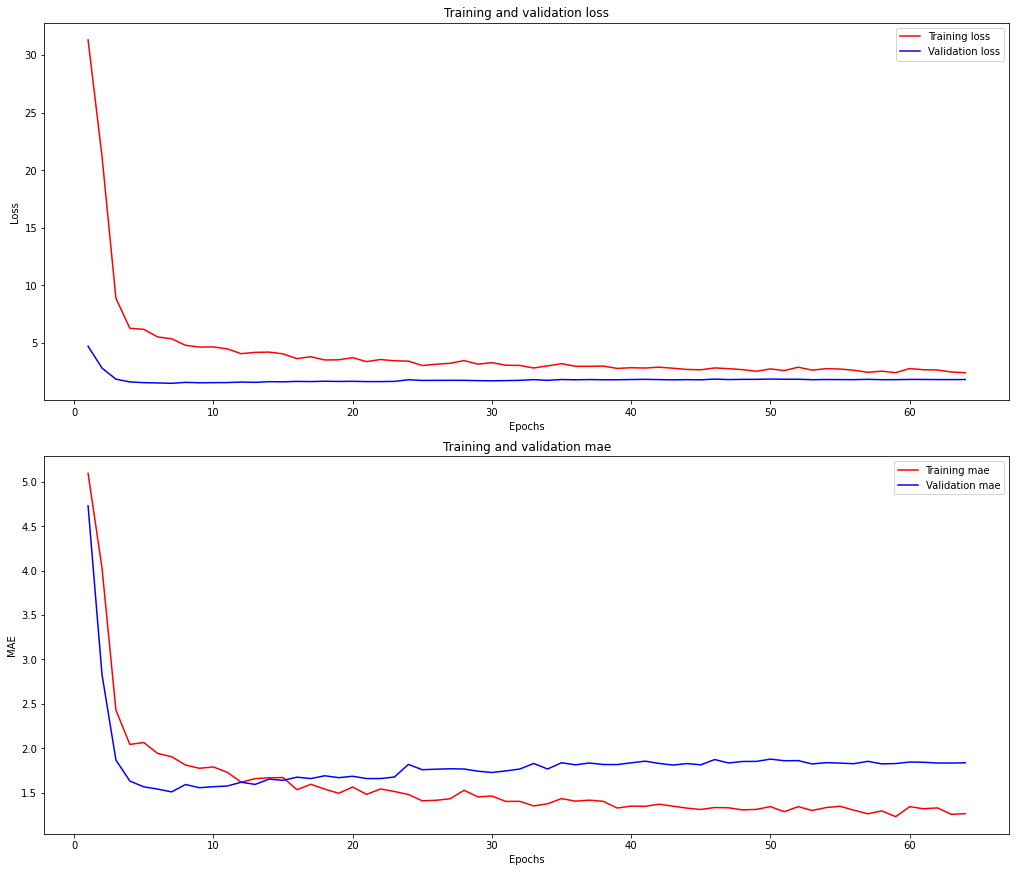

In [8]:
mathbert_regressor_model.plot_training_history_over_time()


### 5. Save model

In [9]:
temp_path = "saved_models/regression/COMBINED_ALL-MATHBERT"
mathbert_regressor_model.model.save(temp_path)


INFO:tensorflow:Assets written to: saved_models/regression/COMBINED_ALL-MATHBERT\assets


INFO:tensorflow:Assets written to: saved_models/regression/COMBINED_ALL-MATHBERT\assets


### Reload model (compare actual & predict)

 1. Let ABC be a triangle, and let P, Q, R be three points in the interiors of the sides BC, CA, AB of this triangle. Prove that the area of at least one of the three triangles AQR, BRP, CPQ is less than or equal to one quarter of the area of triangle ABC. Alternative formulation: Let ABC be a triangle, and let P, Q, R be three points on the segments BC, CA, AB, respectively. Prove that min left { left|AQR right|, left|BRP right|, left|CPQ right| right } leq frac14 cdot left|ABC right|, where the abbreviation left|P_1P_2P_3 right| denotes the (non-directed) area of an arbitrary triangle P_1P_2P_3.
    Actual   Predicted
    0.833    4.655

 2. A circle is inscribed in a triangle ABC with sides a,b,c. Tangents to the circle parallel to the sides of the triangle are contructe. Each of these tangents cuts off a triagnle from triangle ABC. In each of these triangles, a circle is inscribed. Find the sum of the areas of all four inscribed circles (in terms of a,b,c).
    Actual   Predicted
 

,actual,predicted
0,0.833333,4.655122
1,1.157407,5.640276
2,1.509872,5.557092
3,1.510204,5.007320
4,1.559524,5.814594
5,1.947279,7.197674
6,2.212693,5.679050
7,2.601794,7.021938
8,2.777393,4.618001
9,2.815331,7.861942


           actual              predict
Average    6.05006524521902    5.653863430023193
Variance   4.940501510501425    1.583585500717163
STD        2.222723894347075    1.2584059238433838

loss(mse)            mae                   r2
6.619645616427633    2.063593411475703    -0.3398732097049366


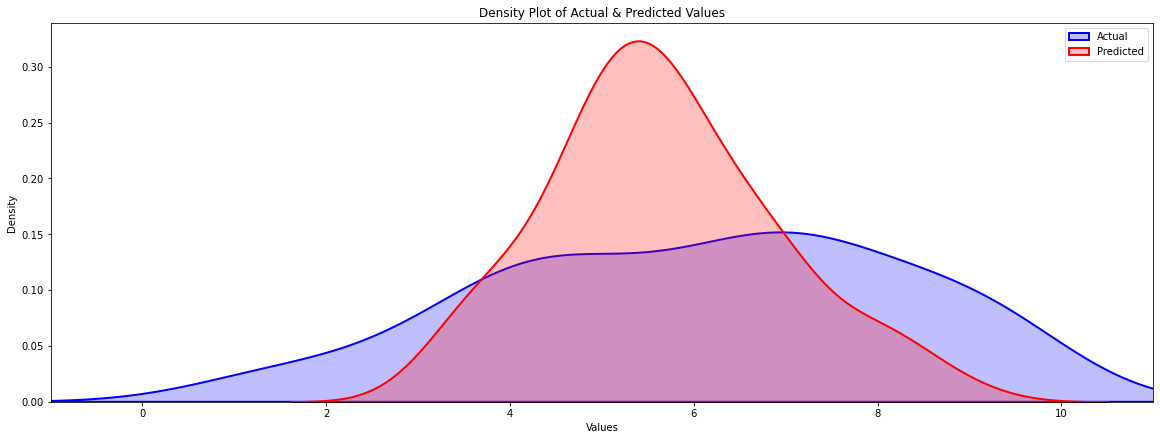

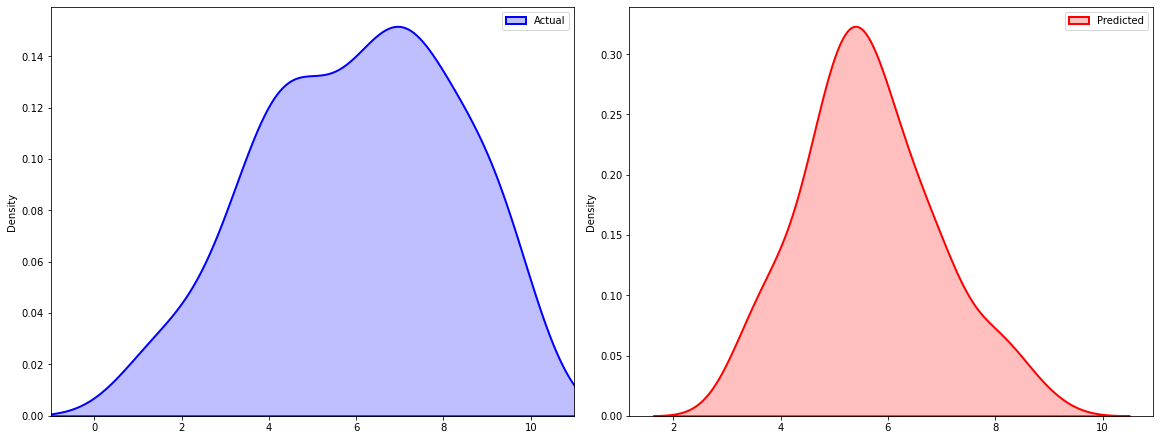

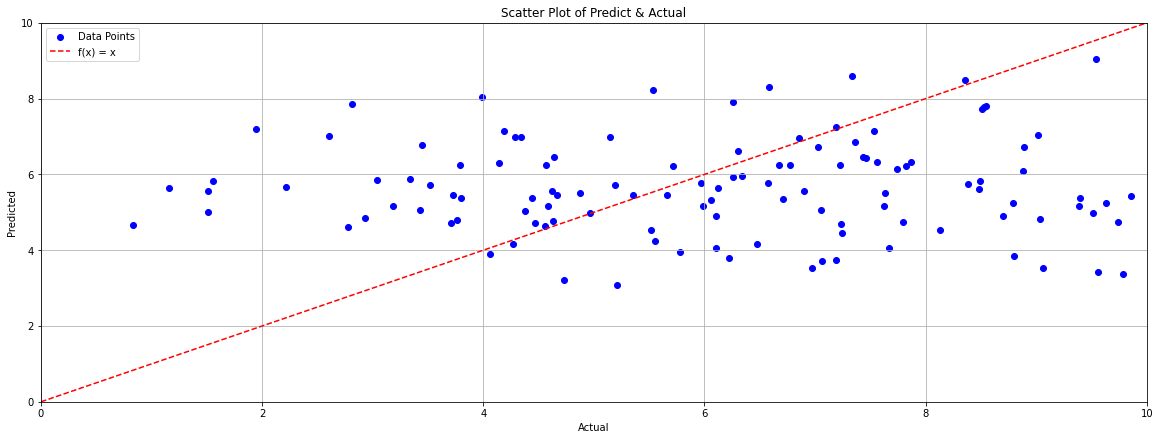

In [2]:
df = pd.read_csv("../data/regression/test.csv")
df.sort_values(by=['score'], inplace=True)
df.reset_index(inplace=True)
examples_texts = list(df['post_canonical'].values)
tokenized_examples_texts = tokenize_text(examples_texts, max_length=512, return_tensor=False)
examples_scores = df['score'].values

reloaded_model = tf.saved_model.load('saved_models/regression/COMBINED_ALL-MATHBERT')
compare_actual_and_predict_values(reloaded_model, tokenized_examples_texts, examples_texts, examples_scores)
